# Imports

In [1]:
import sys
sys.path.append("..")

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from scipy import signal
from auxilliary_funcs.dsp_functions import extract_breath, carrier_snr_from_iq, compute_fft

from auxilliary_funcs.iq_functions import load_iq_auto

# Helper Funcs

In [3]:
def load_belt_csv(p: Path):
    df = pd.read_csv(p)
    return df['epoch_utc_s'].to_numpy(), df['resp_value'].to_numpy()


def read_meta(stem_path: Path):
    """stem_path like .../sdr/pluto_XX_YYYY.bin/.json without extension."""
    meta = json.loads((stem_path.with_suffix(".json")).read_text())
    return {
        "fs": float(meta["sample_rate_hz"]),
        "fc": float(meta["center_frequency_hz"]),
        "t0": float(meta["start_epoch_s"]),
        "raw_path": stem_path.with_suffix(".bin"),
    }


def time_axis(t0_epoch: float, n: int, fs: float):
    return t0_epoch + np.arange(n)/fs


def align_series_to(t_ref, t_src, y_src, refine: bool = False):
    """Interpolate y_src(t_src) -> y_ref(t_ref). If refine=True, do a coarse xcorr."""
    y_interp = np.interp(t_ref, t_src, y_src, left=np.nan, right=np.nan)
    shift = 0.0
    if refine and np.isfinite(y_interp).sum() > 100:
        a = signal.detrend(np.nan_to_num(y_interp))
        # placeholder if you want two-signal refine
        b = signal.detrend(np.nan_to_num(y_interp))
        # (Since we’re already mapping onto t_ref, most runs don’t need refine.)
        # Keep simple & deterministic by default.
    return y_interp, shift


def zscore(x):
    x = x - np.nanmedian(x)
    s = np.nanstd(x)
    return x / (s if s > 0 else 1.0)


def distance_label_from_stem(stem: str) -> str:
    # e.g. ".../10cm_away/session_.../sdr/pluto_..."
    try:
        return Path(stem).parents[2].name.replace("_away", "")
    except Exception:
        return Path(stem).stem


def plot_sdr_belt_overlay(t_rel, sdr, belt, dist_label,
                          sdr_ylabel="SDR instantaneous freq (Hz)",
                          belt_ylabel="Belt (raw units)",
                          title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(t_rel, sdr, color="C0", lw=1.0)
    ax1.set_ylabel(sdr_ylabel, color="C0")
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.set_xlabel("Time (s)")
    ax1.set_xlim(0, t_rel[-1])
    ax1.grid(True, which="both", axis="both", alpha=0.3)

    ax2 = ax1.twinx()
    mask = np.isfinite(belt)
    ax2.plot(t_rel[mask], belt[mask], color="C2", lw=1.0, alpha=0.85)
    ax2.set_ylabel(belt_ylabel, color="C2")
    ax2.tick_params(axis='y', labelcolor='C2')

    title = f"{dist_label.replace('_',' ')}"
    if title_suffix:
        title += f" — {title_suffix}"
    ax1.set_title(title)
    fig.tight_layout()
    plt.show()


def annotate_peak_nf(ax, res, dist_label, color):
    """Annotate peak, noise floor, and SNR on the current spectrum plot."""
    # Pull & cast (keeps Pylance happy)
    fpk = float(res["fpk_mhz"])
    pk = float(res["peak_db"])
    nf = float(res["noise_floor_db"])
    snr = float(res["snr_db"])
    f_roi = np.asarray(res["f_roi"], dtype=float)

    # X-span for smart text placement
    x0, x1 = float(f_roi[0]), float(f_roi[-1])
    span = x1 - x0
    dx = 0.03 * span
    ha = "left"
    if fpk > x1 - 0.08 * span:
        dx, ha = -0.03 * span, "right"

    # Peak marker + annotation (includes SNR)
    ax.scatter([fpk], [pk], color=color, s=30, marker="x", zorder=5)
    ax.annotate(
        f"{dist_label}\nPeak {pk:.1f} dB  |  SNR {snr:.1f} dB",
        xy=(fpk, pk), xytext=(fpk + dx, pk + 3),
        textcoords="data", ha=ha, va="bottom", color=color,
        arrowprops=dict(arrowstyle="->", lw=0.8, color=color),
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.7),
        fontsize=8
    )

    # Noise-floor line + label
    ax.axhline(nf, color=color, ls="--", lw=0.8, alpha=0.5)
    ax.text(x0 + 0.02 * span, nf + 0.5, f"NF {nf:.1f} dB",
            color="black", fontsize=8)

# Breathing Extraction

## Experiment 1: 10cm / 20cm / 30cm / 1m / 2m / 3m Distances

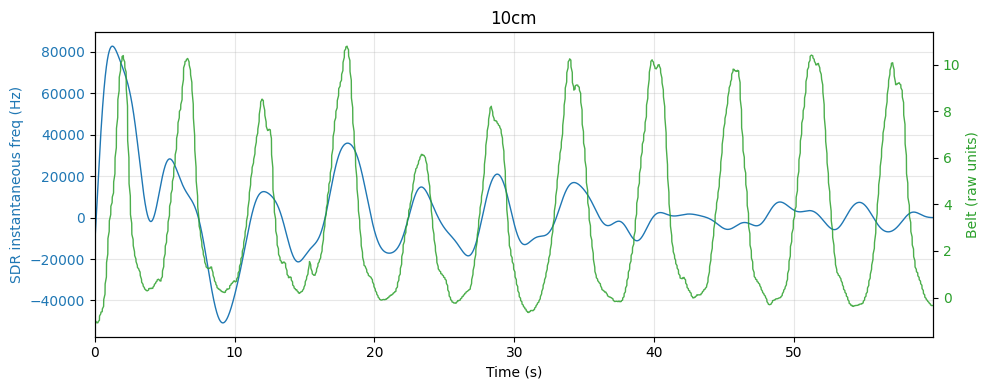

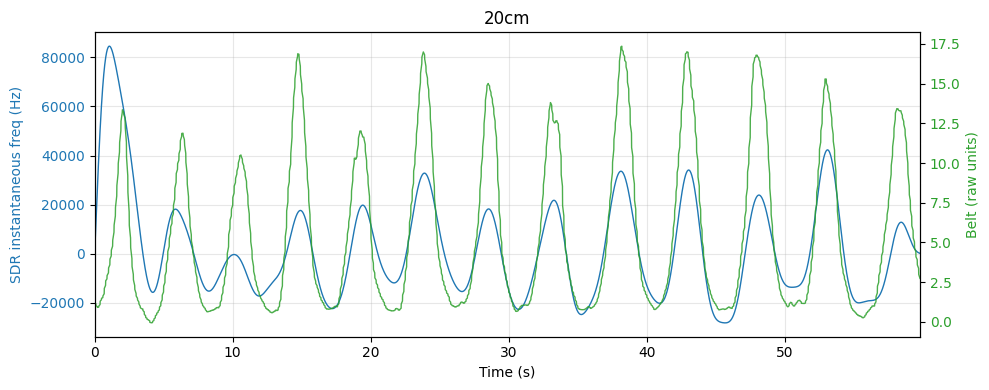

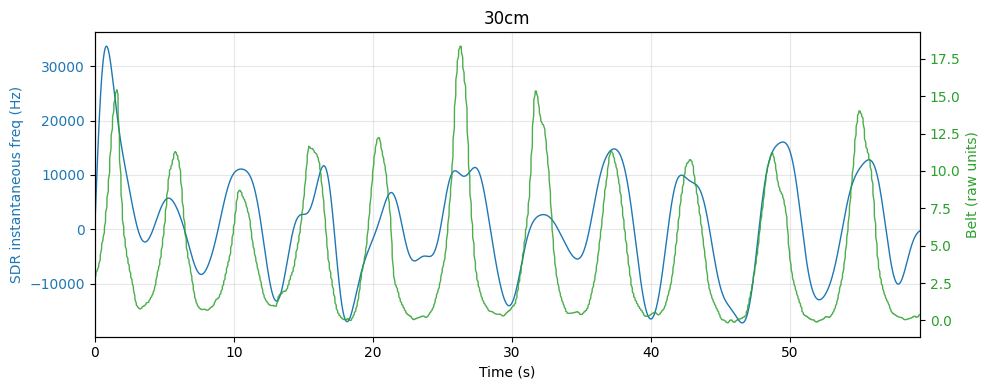

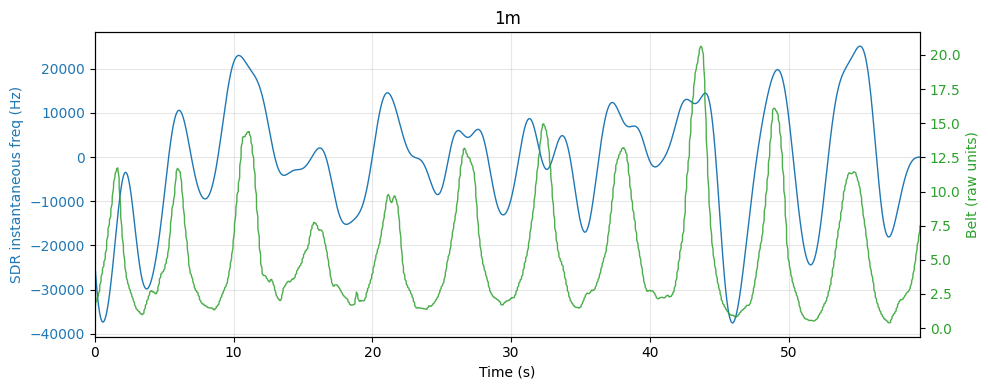

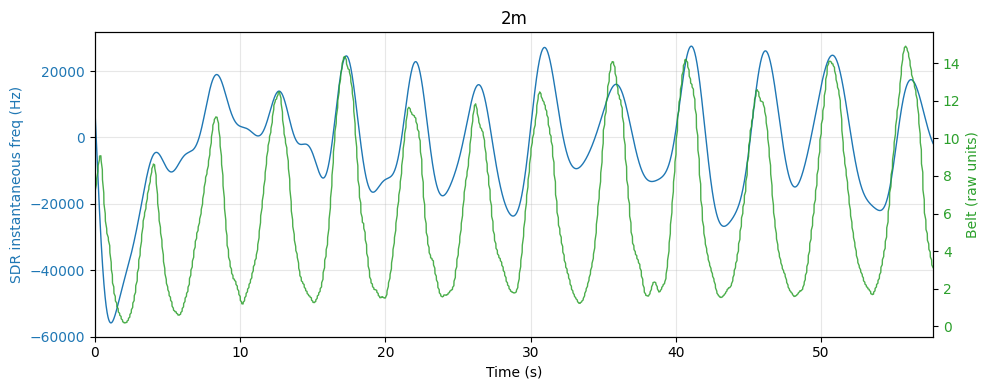

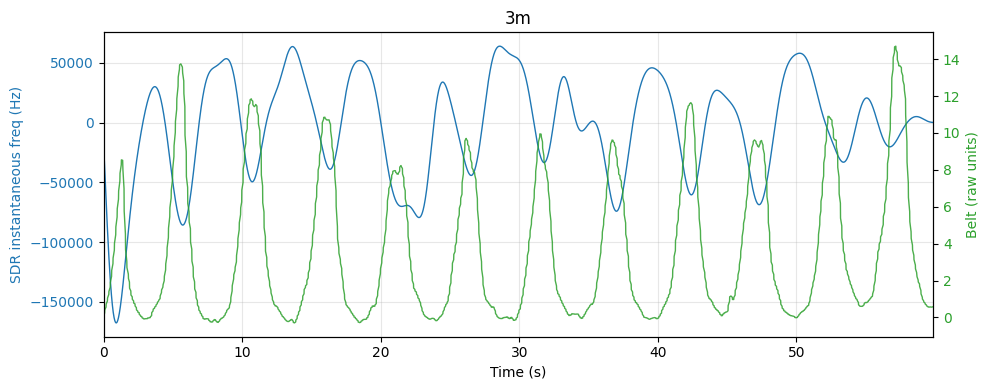

/var/folders/gt/nfyl218x56jclwqp2fx_w08r0000gn/T/ipykernel_97637/228096338.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


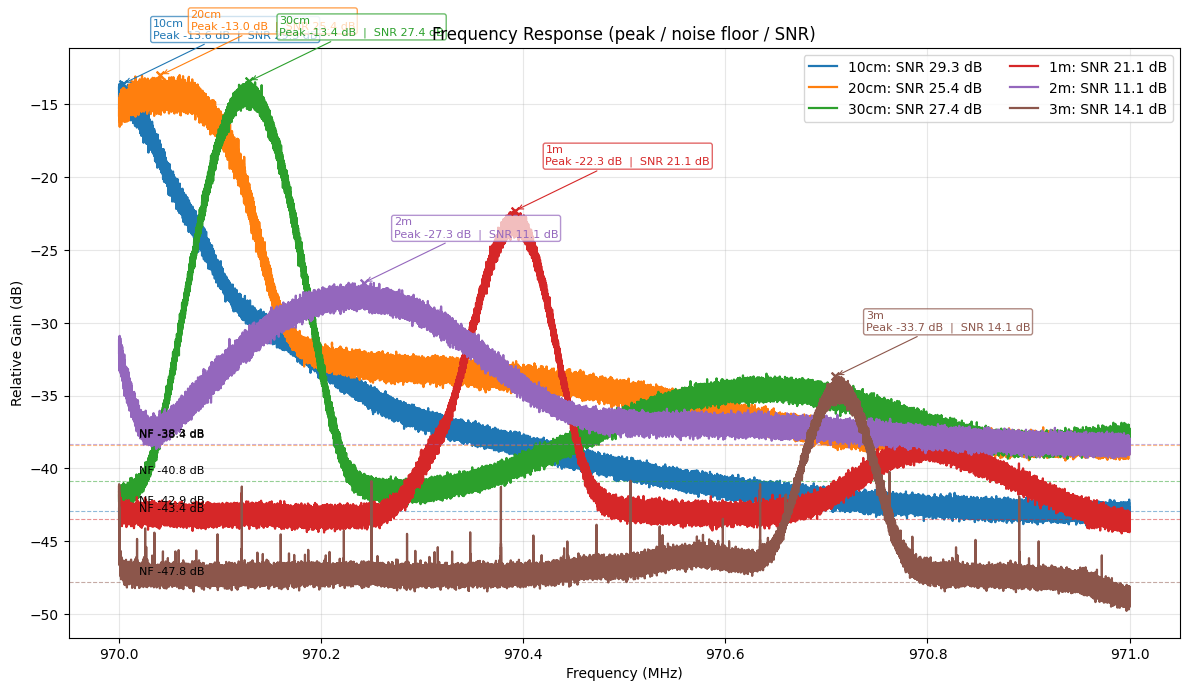

,Distance,Peak dB,Noise Floor (dB),SNR (dB),Peak Freq (MHz),ΔPeak vs ref (dB),ΔNF vs ref (dB)
0,10cm,-13.601563,-42.928370,29.326807,970.003580,0.000000,0.000000
1,20cm,-13.010689,-38.410356,25.399667,970.040858,0.590874,4.518014
2,30cm,-13.424175,-40.848754,27.424578,970.128600,0.177388,2.079616
3,1m,-22.299886,-43.448655,21.148769,970.392012,-8.698323,-0.520285
4,2m,-27.257418,-38.314961,11.057543,970.242001,-13.655855,4.613409
5,3m,-33.676353,-47.789592,14.113239,970.709004,-20.074790,-4.861222


In [4]:
belt_csvs = [
    "sessions/10cm_away/session_20251019T173744/belt/belt_20251019T173744.csv",
    "sessions/20cm_away/session_20251019T172515/belt/belt_20251019T172515.csv",
    "sessions/30cm_away/session_20251019T173350/belt/belt_20251019T173350.csv",
    "sessions/1m_away/session_20251019T175815/belt/belt_20251019T175815.csv",
    "sessions/2m_away/session_20251019T165619/belt/belt_20251019T165619.csv",
    "sessions/3m_away/session_20251019T180611/belt/belt_20251019T180611.csv",
]
# 'sessions/1m_away/session_20251019T085622Z/sdr/pluto_100cm_2000000Sps_int16_60s.json'

iq_stems = [
    "sessions/10cm_away/session_20251019T093744Z/sdr/pluto_10cm_2000000Sps_int16_60s",
    "sessions/20cm_away/session_20251019T092515Z/sdr/pluto_20cm_2000000Sps_int16_60s",
    "sessions/30cm_away/session_20251019T093351Z/sdr/pluto_30cm_2000000Sps_int16_60s",
    # session_20251019T095815Z
    "sessions/1m_away/session_20251019T095815Z/sdr/pluto_100cm_2000000Sps_int16_60s",
    "sessions/2m_away/session_20251019T085622Z/sdr/pluto_200cm_2000000Sps_int16_60s",
    "sessions/3m_away/session_20251019T100611Z/sdr/pluto_300cm_2000000Sps_int16_60s",
]

# ---------------- main loop (now uses extract_breath) ----------------
for belt_csv, iq_stem in zip(belt_csvs, iq_stems):
    # Belt
    belt_t, belt_y = load_belt_csv(Path(belt_csv))

    # SDR meta & IQ
    info = read_meta(Path(iq_stem))
    fs, fc, t0 = info["fs"], info["fc"], info["t0"]
    x = load_iq_auto(info["raw_path"])  # complex64/complex128

    breath, Fs_out = extract_breath(
        x,
        fs_raw=fs,
        decim1=100,               # 2e6 -> 20 kHz
        decim2=200,               # 20 kHz -> 100 Hz
        f_band=(0.05, 0.5),       # breathing band
        remove_cfo=True
    )
    t_breath = time_axis(t0, len(breath), Fs_out)

    # Overlap window
    t_min = max(t_breath[0], belt_t[0])
    t_max = min(t_breath[-1], belt_t[-1])
    sel = (t_breath >= t_min) & (t_breath <= t_max)
    t_b = t_breath[sel]
    breath_ovl = breath[sel]

    # Align belt → SDR timebase (simple interpolation)
    belt_aligned, _ = align_series_to(t_b, belt_t, belt_y, refine=False)

    # Relative x-axis
    t_rel = t_b - t_b[0]

    # Optional normalization for correlation / visualization balance
    breath_z = zscore(breath_ovl)
    belt_z = zscore(belt_aligned)

    valid = np.isfinite(belt_z)
    corr = (np.corrcoef(breath_z[valid], belt_z[valid])[0, 1]
            if valid.sum() > 10 else np.nan)

    dist_label = distance_label_from_stem(iq_stem)
    # print(f"{dist_label}: Fs_out={Fs_out:.1f} Hz, overlap={len(t_rel)} samples, corr={corr:.3f}")

    # Plot raw (or swap to z-scored if you prefer)
    plot_sdr_belt_overlay(
        t_rel,
        breath_ovl,
        belt_aligned,
        dist_label,
        # title_suffix=f"corr {corr:.2f}"
    )

rows = []
# plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
for stem in iq_stems:
    meta = json.loads(Path(stem + ".json").read_text())
    fs_hz = float(meta["sample_rate_hz"])
    fc_hz = float(meta["center_frequency_hz"])
    fc_mhz = fc_hz / 1e6
    x = load_iq_auto(Path(stem + ".bin"))

    # compute SNR/peak/NF via reusable fn
    res = carrier_snr_from_iq(
        x, fs_hz, fc_hz,
        ma_win=1001, edge_trim=5000, prom_db=2.0,
        min_width_khz=30.0, exclude_width_mhz=0.15
    )

    # nice label from path
    try:
        dist_label = Path(stem).parents[2].name.replace("_away", "")
    except Exception:
        dist_label = Path(stem).stem

    rows.append({
        "Distance": dist_label,
        "Peak dB": res["peak_db"],
        "Noise Floor (dB)": res["noise_floor_db"],
        "SNR (dB)": res["snr_db"],
        "Peak Freq (MHz)": res["fpk_mhz"],
    })

    xv = float(res["fpk_mhz"])
    yv = float(res["peak_db"])
    nf = float(res["noise_floor_db"])

    # (line,) = plt.plot(res["f_roi"], np.asarray(res["y_roi"], dtype=float), lw=1.6,
    #                    label=f"{dist_label}: SNR {float(res['snr_db']):.1f} dB")
    # c = line.get_color()

    # plt.scatter([xv], [yv], color=c, s=30, marker='x', zorder=5)
    # plt.axhline(nf, color=c, ls="--", lw=0.8, alpha=0.5)

    (line,) = ax.plot(res["f_roi"], res["y_roi"], lw=1.6,
                      label=f"{dist_label}: SNR {float(res['snr_db']):.1f} dB")
    c = line.get_color()
    ax.scatter([xv], [yv], color=c, s=30, marker='x', zorder=5)
    annotate_peak_nf(ax, res, dist_label, c)


plt.xlabel("Frequency (MHz)")
plt.ylabel("Relative Gain (dB)")
plt.title("Frequency Response (peak / noise floor / SNR)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

tbl = pd.DataFrame(rows)
for col in ["Peak dB", "Noise Floor (dB)", "SNR (dB)", "Peak Freq (MHz)"]:
    tbl[col] = pd.to_numeric(tbl[col], errors="coerce")

if len(tbl):
    ref_peak = float(tbl.loc[0, "Peak dB"])
    ref_nf = float(tbl.loc[0, "Noise Floor (dB)"])
    tbl["ΔPeak vs ref (dB)"] = tbl["Peak dB"].astype(float) - ref_peak
    tbl["ΔNF vs ref (dB)"] = tbl["Noise Floor (dB)"].astype(float) - ref_nf

display(tbl)

## Experiment 2: 5m / 8m / Outside Classroom / Next Door

/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in multiply
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in add
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: overflow encountered in cast
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudD

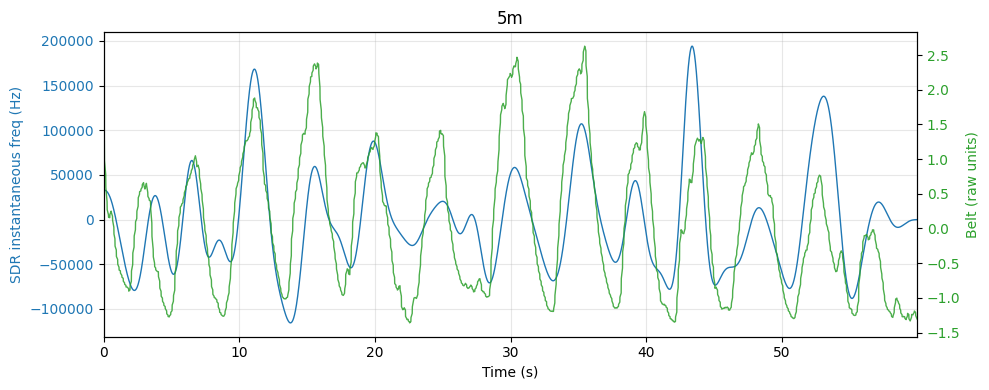

/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in multiply
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in add
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: overflow encountered in cast
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudD

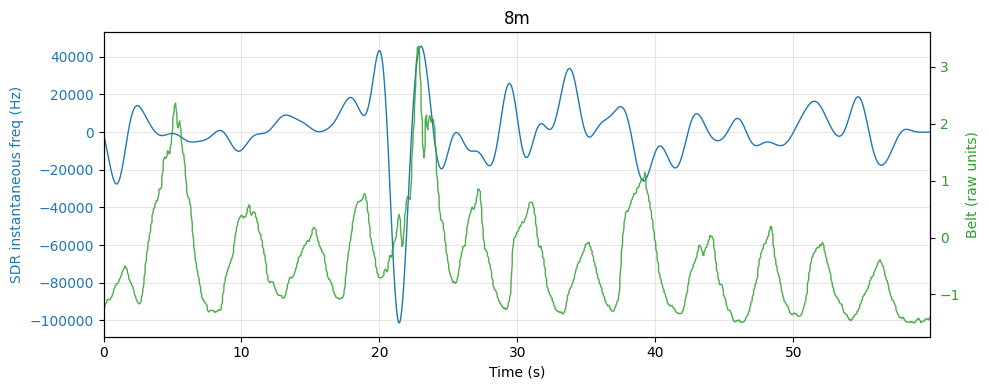

/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in multiply
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in add
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: overflow encountered in cast
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudD

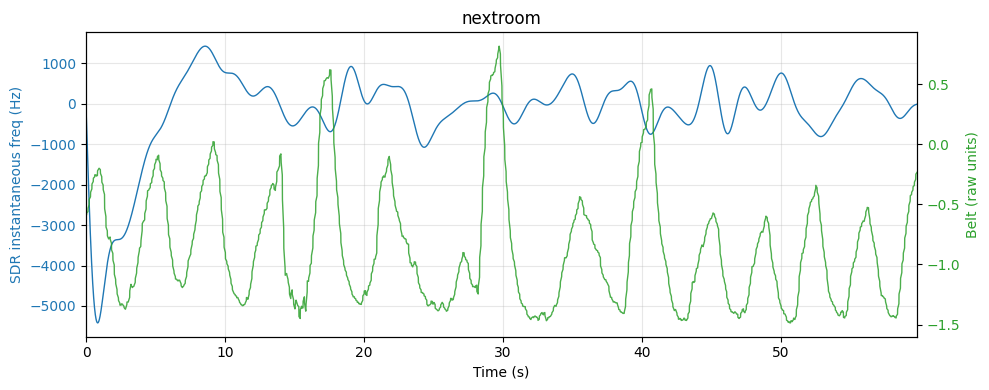

/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in multiply
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: invalid value encountered in add
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/scripts/../auxilliary_funcs/iq_functions.py:20: RuntimeWarning: overflow encountered in cast
  x = I.astype(np.float32) + 1j*Q.astype(np.float32)
/Users/andreteo/Library/Mobile Documents/com~apple~CloudD

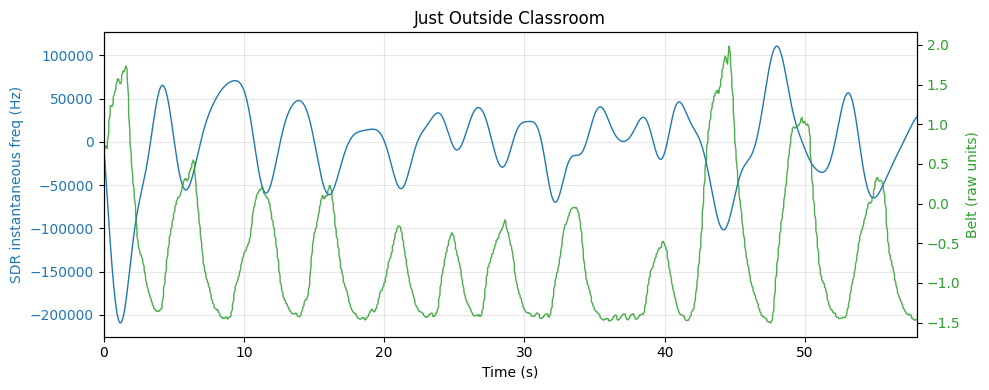

/var/folders/gt/nfyl218x56jclwqp2fx_w08r0000gn/T/ipykernel_24440/3950309118.py:144: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/andreteo/Library/Mobile Documents/com~apple~CloudDocs/Documents/NUS/MComp General Track/Courses/CP5105/Code/heartbeats-and-respiration-sensing-using-wifi-ml/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


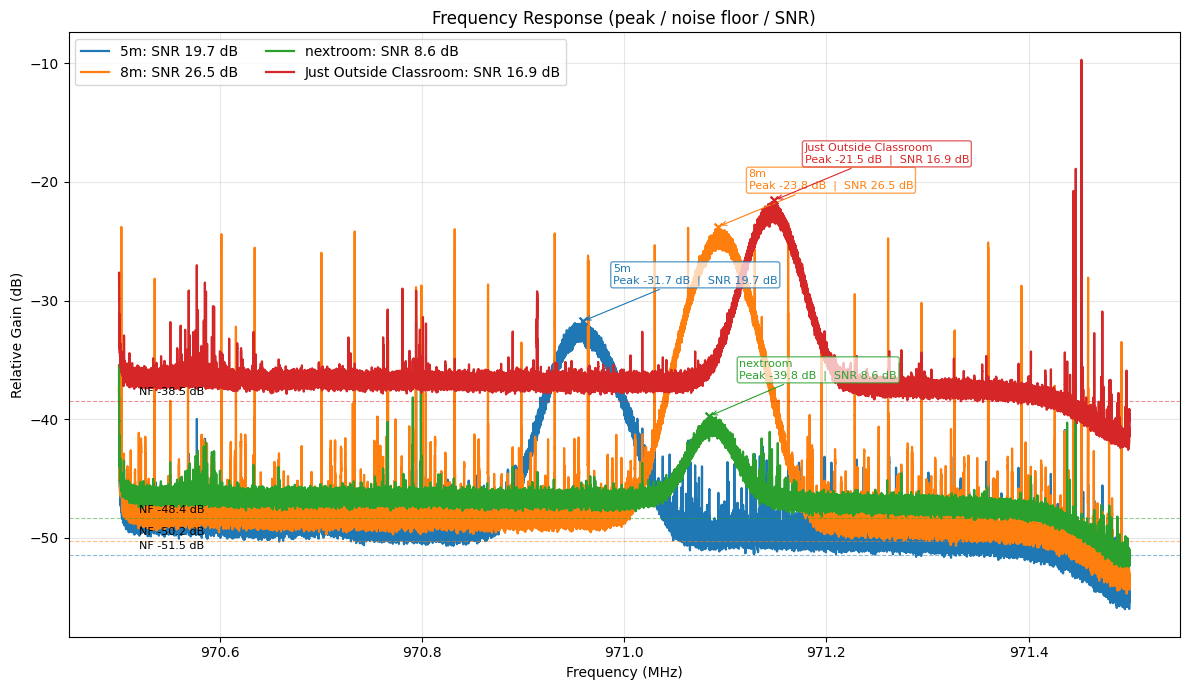

,Distance,Peak dB,Noise Floor (dB),SNR (dB),Peak Freq (MHz),ΔPeak vs ref (dB),ΔNF vs ref (dB)
0,5m,-31.743229,-51.463308,19.720079,970.958843,0.000000,0.000000
1,8m,-23.764648,-50.232270,26.467622,971.093065,7.978581,1.231038
2,nextroom,-39.750576,-48.372318,8.621742,971.083972,-8.007347,3.090990
3,Just Outside Classroom,-21.544123,-38.473684,16.929560,971.148455,10.199106,12.989624


In [4]:
import re

belt_csvs = [
    '/Users/andreteo/Downloads/sessions_20251023/belt_20251023/session_20251023T204157/belt/belt_20251023T204157.csv',
    '/Users/andreteo/Downloads/sessions_20251023/belt_20251023/session_20251023T205042/belt/belt_20251023T205042.csv',
    '/Users/andreteo/Downloads/sessions_20251023/belt_20251023/session_20251023T205527/belt/belt_20251023T205527.csv',
    '/Users/andreteo/Downloads/sessions_20251023/belt_20251023/session_20251023T210109/belt/belt_20251023T210109.csv'
]

iq_stems = [
    '/Users/andreteo/Downloads/sessions_20251023/sdr_20251023/session_20251023T124157Z/sdr/pluto_5m_2000000Sps_int16_60s',
    '/Users/andreteo/Downloads/sessions_20251023/sdr_20251023/session_20251023T125042Z/sdr/pluto_8m_2000000Sps_int16_60s',
    '/Users/andreteo/Downloads/sessions_20251023/sdr_20251023/session_20251023T125527Z/sdr/pluto_nextroom_2000000Sps_int16_60s',
    '/Users/andreteo/Downloads/sessions_20251023/sdr_20251023/session_20251023T130111Z/sdr/pluto_justoutside_2000000Sps_int16_60s'
]


PATTERN = re.compile(
    r"/pluto_(?P<label>(?:\d+(?:cm|m)|nextroom|justoutside))_")


def config_label_from_path(p: str) -> str:
    m = PATTERN.search(p)
    if not m:
        return "unknown"
    raw = m.group("label")
    # prettify
    if raw.endswith(("cm", "m")):
        # insert space for readability
        return raw[:-2] + " " + raw[-2:] if raw.endswith("cm") else raw[:-1] + "m"
    return {"nextroom": "Adjacent Room", "justoutside": "Just Outside Classroom"}[raw]


# ---------------- main loop (now uses extract_breath) ----------------
for belt_csv, iq_stem in zip(belt_csvs, iq_stems):
    # Belt
    belt_t, belt_y = load_belt_csv(Path(belt_csv))

    # SDR meta & IQ
    info = read_meta(Path(iq_stem))
    fs, fc, t0 = info["fs"], info["fc"], info["t0"]
    x = load_iq_auto(info["raw_path"])  # complex64/complex128

    iq_label = config_label_from_path(iq_stem)

    breath, Fs_out = extract_breath(
        x,
        fs_raw=fs,
        decim1=100,               # 2e6 -> 20 kHz
        decim2=200,               # 20 kHz -> 100 Hz
        f_band=(0.05, 0.5),       # breathing band
        remove_cfo=True
    )
    t_breath = time_axis(t0, len(breath), Fs_out)

    # Overlap window
    t_min = max(t_breath[0], belt_t[0])
    t_max = min(t_breath[-1], belt_t[-1])
    sel = (t_breath >= t_min) & (t_breath <= t_max)
    t_b = t_breath[sel]
    breath_ovl = breath[sel]

    # Align belt → SDR timebase (simple interpolation)
    belt_aligned, _ = align_series_to(t_b, belt_t, belt_y, refine=False)

    # Relative x-axis
    t_rel = t_b - t_b[0]

    # Optional normalization for correlation / visualization balance
    breath_z = zscore(breath_ovl)
    belt_z = zscore(belt_aligned)

    valid = np.isfinite(belt_z)
    corr = (np.corrcoef(breath_z[valid], belt_z[valid])[0, 1]
            if valid.sum() > 10 else np.nan)

    dist_label = iq_label

    # Plot raw (or swap to z-scored if you prefer)
    plot_sdr_belt_overlay(
        t_rel,
        breath_ovl,
        belt_aligned,
        dist_label,
        # title_suffix=f"corr {corr:.2f}"
    )


rows = []
# plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
for stem in iq_stems:
    meta = json.loads(Path(stem + ".json").read_text())
    fs_hz = float(meta["sample_rate_hz"])
    fc_hz = float(meta["center_frequency_hz"])
    fc_mhz = fc_hz / 1e6
    x = load_iq_auto(Path(stem + ".bin"))

    # compute SNR/peak/NF via reusable fn
    res = carrier_snr_from_iq(
        x, fs_hz, fc_hz,
        ma_win=1001, edge_trim=5000, prom_db=2.0,
        min_width_khz=30.0, exclude_width_mhz=0.15
    )

    dist_label = config_label_from_path(stem)

    # try:
    #     dist_label = Path(stem).parents[2].name.replace("_away", "")
    # except Exception:
    #     dist_label = Path(stem).stem

    rows.append({
        "Distance": dist_label,
        "Peak dB": res["peak_db"],
        "Noise Floor (dB)": res["noise_floor_db"],
        "SNR (dB)": res["snr_db"],
        "Peak Freq (MHz)": res["fpk_mhz"],
    })

    xv = float(res["fpk_mhz"])
    yv = float(res["peak_db"])
    nf = float(res["noise_floor_db"])

    # (line,) = plt.plot(res["f_roi"], np.asarray(res["y_roi"], dtype=float), lw=1.6,
    #                    label=f"{dist_label}: SNR {float(res['snr_db']):.1f} dB")
    # c = line.get_color()

    # plt.scatter([xv], [yv], color=c, s=30, marker='x', zorder=5)
    # plt.axhline(nf, color=c, ls="--", lw=0.8, alpha=0.5)

    (line,) = ax.plot(res["f_roi"], res["y_roi"], lw=1.6,
                      label=f"{dist_label}: SNR {float(res['snr_db']):.1f} dB")
    c = line.get_color()
    ax.scatter([xv], [yv], color=c, s=30, marker='x', zorder=5)
    annotate_peak_nf(ax, res, dist_label, c)


plt.xlabel("Frequency (MHz)")
plt.ylabel("Relative Gain (dB)")
plt.title("Frequency Response (peak / noise floor / SNR)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

tbl = pd.DataFrame(rows)
for col in ["Peak dB", "Noise Floor (dB)", "SNR (dB)", "Peak Freq (MHz)"]:
    tbl[col] = pd.to_numeric(tbl[col], errors="coerce")

if len(tbl):
    ref_peak = float(tbl.loc[0, "Peak dB"])
    ref_nf = float(tbl.loc[0, "Noise Floor (dB)"])
    tbl["ΔPeak vs ref (dB)"] = tbl["Peak dB"].astype(float) - ref_peak
    tbl["ΔNF vs ref (dB)"] = tbl["Noise Floor (dB)"].astype(float) - ref_nf

display(tbl)